# Bringing in the data and importing all necessary libraries
* Download the dataset from kaggle and save it in the present working directory 
* Link for the download is as follows:https://www.kaggle.com/datasets/parthdande/timeseries-weather-dataset

In [1]:
# !pip install pyhomogeneity plotly scipy matplotlib sklearn ruptures pymannkendall numpy pandas


In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import pymannkendall as mk
import ruptures as rpt
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import norm
import statsmodels.api as sm
from pyhomogeneity import pettitt_test
import plotly.io as pio
import gc
gc.collect()





0

# Converting the time column as an index col and changing its datatype as datetime

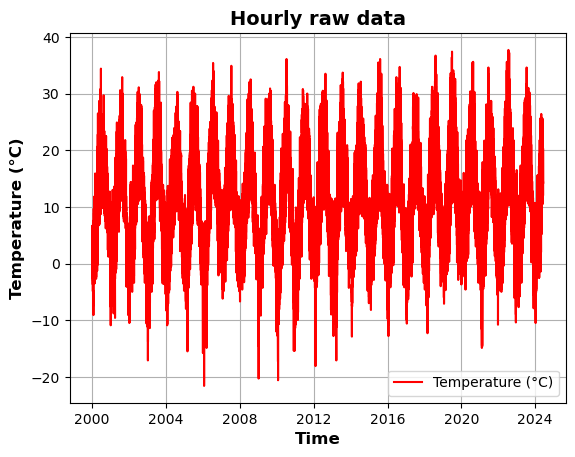

In [3]:
df=pd.read_csv("Weather_dataset.csv",index_col=['time'],parse_dates=['time'],usecols=['time','temperature'])
df.head()
plt.plot(df,color='red',label='Temperature (°C)')
plt.title('Hourly raw data',fontsize=14, fontweight='bold')
plt.xlabel('Time', fontsize=12, fontweight='bold')
plt.ylabel('Temperature (°C)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True)
plt.savefig('raw_data_hourly_plot.png', format='png') 
plt.show()


# I want to work on daily mean temp instead of hourl data so i am converting it to daily using resample and then taking mean of it

In [4]:
df=df.resample('D').mean()
df.head()


,temperature
time,
2000-01-01,0.875000
2000-01-02,3.275000
2000-01-03,5.391667
2000-01-04,5.425000
2000-01-05,3.550000


In [5]:
df.tail()

,temperature
time,
2024-06-01,20.137500
2024-06-02,18.804167
2024-06-03,15.050000
2024-06-04,16.258333
2024-06-05,16.512500


In [6]:
df.describe()

,temperature
count,8923.000000
mean,10.247511
std,7.770567
min,-18.070833
25%,4.258333
50%,10.233333
75%,16.558333
max,30.308333


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8923 entries, 2000-01-01 to 2024-06-05
Freq: D
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  8923 non-null   float64
dtypes: float64(1)
memory usage: 139.4 KB


# Lets plot the Raw Data 
* Full Data Plot
* 100 Day Data Plot

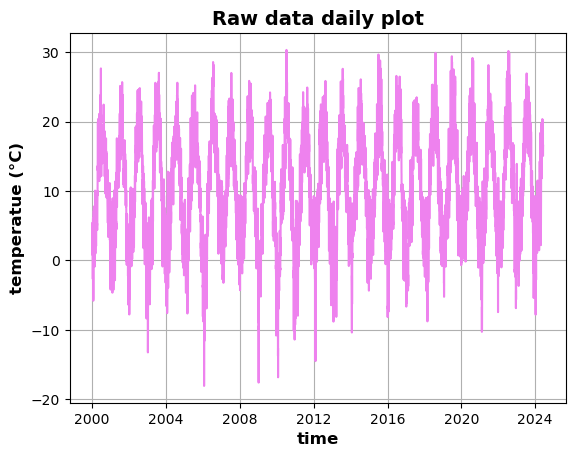

In [8]:
plt.plot(df,color='violet')
plt.title('Raw data daily plot',fontsize=14, fontweight='bold')
plt.xlabel('time',fontsize=12, fontweight='bold')
plt.ylabel('temperatue (°C)',fontsize=12, fontweight='bold')
plt.grid(True)
plt.savefig('raw_data_daily_plot.png', format='png') 
plt.show()

<Figure size 640x480 with 0 Axes>

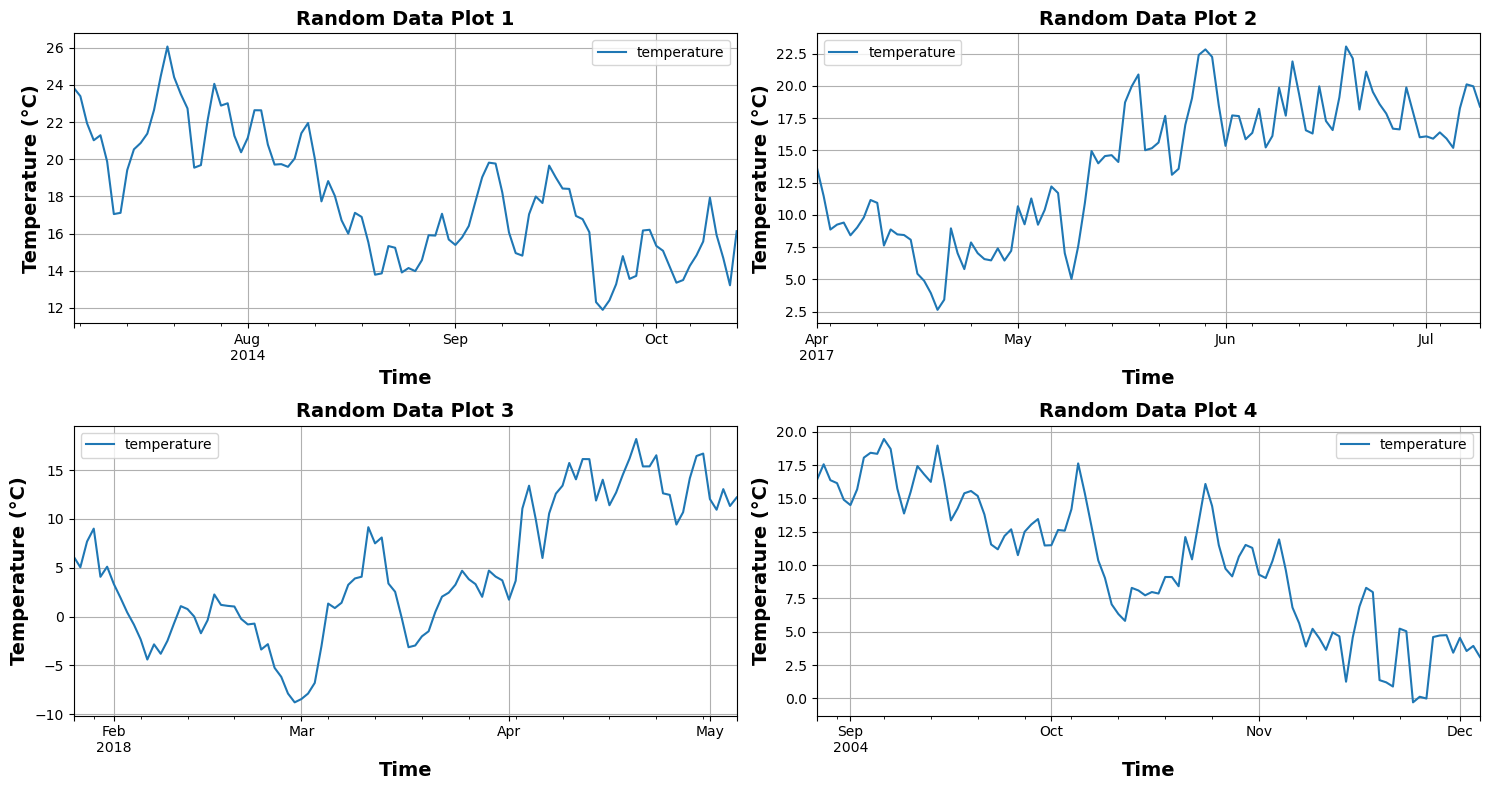

In [9]:
# Randomly select 6 start indices for 100-row chunks
plt.figure()
random_indices = np.random.choice(range(0, len(df), 100), size=4, replace=False)

# Create subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

for i in range(4):
    # Convert 2D axes to 1D index for iteration
    ax = axes.flatten()[i]
    
    # Selecting the slice of data for each random index
    start_idx = random_indices[i]
    df.iloc[start_idx:start_idx + 100, :].plot(ax=ax, title=f'Random data plot {i+1}')

    ax.grid(True)
    
    ax.set_title(f'Random Data Plot {i+1}', fontsize=14, fontweight='bold')

    # Increase labels size
    ax.set_xlabel('Time', fontsize=14, fontweight='bold')
    ax.set_ylabel('Temperature (°C)', fontsize=14, fontweight='bold')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig('random_data_plots.png',format='png')
plt.show()


# Now we have the daily temperature data lets save it so we don't need to perform above steps again

In [10]:
df=pd.DataFrame(df)
df.to_csv("daily_temp_data.csv")


In [11]:
#  read the daily data
df=pd.read_csv('daily_temp_data.csv')


df['time']=pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df 

,temperature
time,
2000-01-01,0.875000
2000-01-02,3.275000
2000-01-03,5.391667
2000-01-04,5.425000
2000-01-05,3.550000
...,...
2024-06-01,20.137500
2024-06-02,18.804167
2024-06-03,15.050000


# Plot the moving averages of the data for 7 day, 30 day and 90 day window

In [12]:
df['moving_avg_7d']=df['temperature'].rolling(window=7).mean()
df['moving_avg_30d']=df['temperature'].rolling(window=30).mean()
df['moving_avg_90d']=df['temperature'].rolling(window=90).mean()

In [13]:
df.head(60)

,temperature,moving_avg_7d,moving_avg_30d,moving_avg_90d
time,,,,
2000-01-01,0.875000,NaN,NaN,NaN
2000-01-02,3.275000,NaN,NaN,NaN
2000-01-03,5.391667,NaN,NaN,NaN
2000-01-04,5.425000,NaN,NaN,NaN
2000-01-05,3.550000,NaN,NaN,NaN
2000-01-06,0.983333,NaN,NaN,NaN
2000-01-07,4.954167,3.493452,NaN,NaN
2000-01-08,4.316667,3.985119,NaN,NaN
2000-01-09,4.350000,4.138690,NaN,NaN


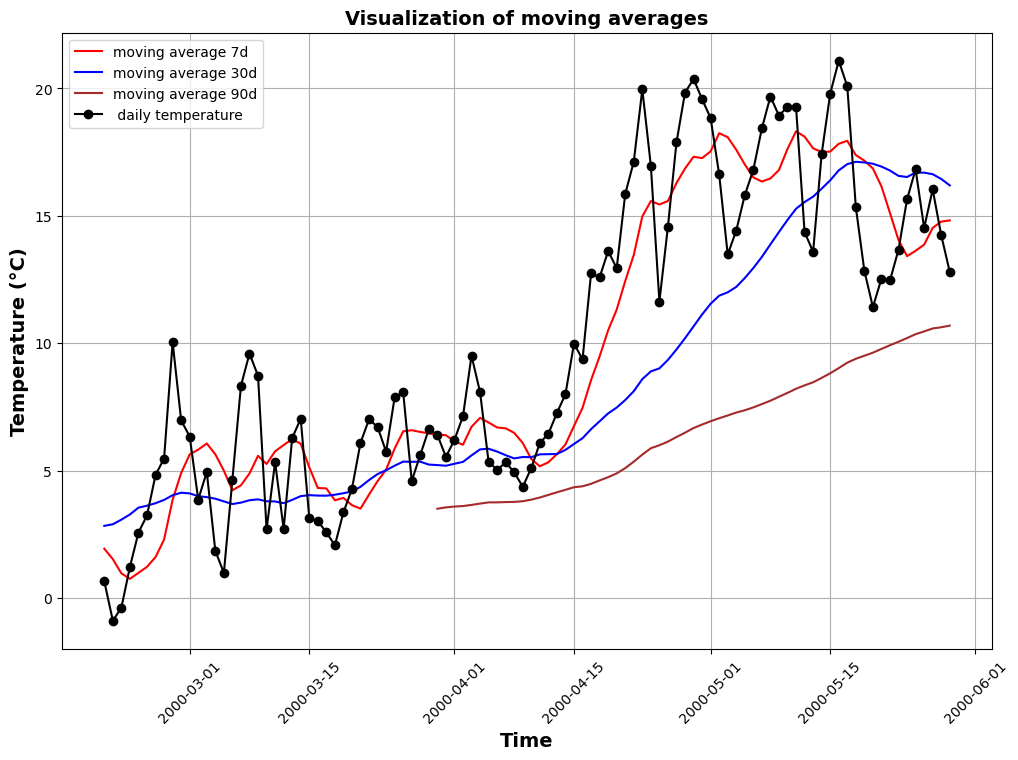

In [14]:
x=df.iloc[50:150,:]
plt.figure(figsize=(12,8))
plt.plot(x.index,x['moving_avg_7d'],color='red',label='moving average 7d',)
plt.plot(x.index,x['moving_avg_30d'],color='blue',label='moving average 30d')
plt.plot(x.index,x['moving_avg_90d'],color='brown',label='moving average 90d')
plt.plot(x.index,x['temperature'],'-o',color='black',label=' daily temperature')
plt.xlabel('Time',fontsize=14,fontweight='bold')
plt.ylabel('Temperature (°C)',fontsize=14,fontweight='bold')
plt.legend()
plt.title('Visualization of moving averages',fontsize=14,fontweight='bold')
plt.grid(True)
plt.xticks(rotation=45)
plt.savefig('moving_avg_chunk.png',format='png')
plt.show()


# We are able to see the data but we cant make it more interactive or look whole data at once 
# Lets use the plotly a plotting library to plot our data in more interactive way

In [15]:
#  we need to create a figure object to plot further
# then specify the plot in fig.add_trace() like scatter scatter3d and so on..
# use dict to specify colors of each line could also use width,dash to make dashed line

pio.renderers.default = "notebook"

fig=go.Figure()
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['temperature'],
    mode='lines+markers',
    name='Temperature',
    line=dict(color='red')
    ))

fig.add_trace(go.Scatter(
    x=df.index,
    y=df['moving_avg_7d'],
    mode='lines',
    name='moving avg 7 day',
    line=dict(color='black')
    ))

fig.add_trace(go.Scatter(
    x=df.index,
    y=df['moving_avg_30d'],
    mode='lines',
    name='moving avg 30 day',
    line=dict(color='violet')
    ))

fig.add_trace(go.Scatter(
    x=df.index,
    y=df['moving_avg_90d'],
    mode='lines',
    name='moving avg 90 day',
    line=dict(color='blue')
    ))

fig.update_layout(
    title=dict(
        text='Visualization of Moving Averages with Plotly',
        x=0.5,  # Center the title
        xanchor='center',
        yanchor='top'
    ),
    
    xaxis_title='Time',
    yaxis_title='Daily Temperature (°C)',
    legend=dict(
        orientation="h",  # Horizontal legend
        yanchor="bottom",  # Position the legend at the bottom
        y=1,  # Position above the plot
        xanchor="center",  # Center the legend horizontally
        x=0.5  # Align the legend in the center
    )
)

fig.show(renderer='iframe')


# Linear Regression
# Lets try to fit a line through the data 
* Lets use our own logic first to do simple linear regression 
* Try to verify it with scikit-learn implementation
* Most important try to find if it follows trend


## Two approaches are present Odinary-least-square(ols) and Gradient-descent 
## As of my knowledge scikit learn uses ols method internally and SGD-regressor class uses Gradient descent. we can also use the statmodels.api to fit the data using ols and calculate the p-value.
## OLS is a good approach if the dimensions of the data is less so i would prefer to use this one
## To reduce the error function we have two tunning knobs one is slope and another is y-intercept
## so error function is like this E(m,b)= Σ (y-y_hat)^2 (Differentitate partially  both the variables to get the value of m and b and equate to zero to find the minimum)
## b=yˉ−m xˉ
 
## m=(Σ(xi-xˉ)(yi-yˉ))/Σ(xi-xˉ)^2


In [16]:
class Mylinearregression:
    def __init__(self):
        self.m=None
        self.b=None
        
    def fit(self,X_train,y_train):
        num=0
        den=0
        for i in range(X_train.shape[0]):
            num=num+(X_train[i]-X_train.mean())*(y_train[i]-y_train.mean())
            den=den+(X_train[i]-X_train.mean())**2
        self.m=num/den
        self.b=y_train.mean()-self.m*X_train.mean()
        print(f"Slope of the line fitted to data is {self.m}")
        print(f"Y-intercept of the line fitted to data is {self.b}")
        
        return self.m,self.b
    def predict(self,X_test):
        return X_test*self.m+self.b
    
    
    
X_linear=np.array(df.index.map(pd.Timestamp.toordinal)).reshape(-1, 1)
y_linear=df['temperature'].values
lr=Mylinearregression()
m,b=lr.fit(X_linear,y_linear)
prediction_line = pd.Series(lr.predict(X_linear).flatten(), index=df.index)



X_linear_smoothed = np.array(df['moving_avg_30d'].dropna().index.map(pd.Timestamp.toordinal)).reshape(-1, 1)
y_linear_smoothed = df['moving_avg_30d'].dropna().values
lr_smoothed = Mylinearregression()
m_smoothed, b_smoothed = lr_smoothed.fit(X_linear_smoothed, y_linear_smoothed)
prediction_line_smoothed = pd.Series(lr_smoothed.predict(X_linear_smoothed).flatten(), index=df['moving_avg_30d'].dropna().index)


Slope of the line fitted to data is [0.00015745]
Y-intercept of the line fitted to data is [-105.41414918]
Slope of the line fitted to data is [0.00014166]
Y-intercept of the line fitted to data is [-93.81238518]


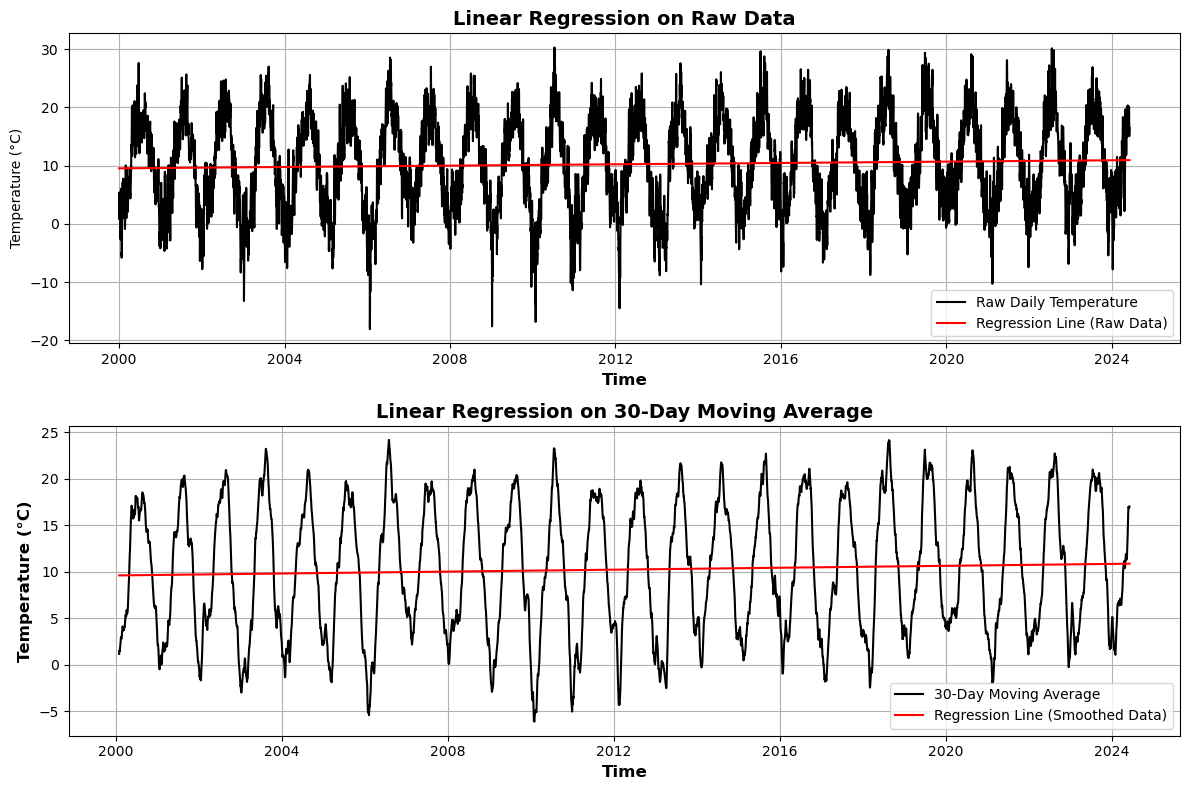

R² Score for raw data linear regression: 0.0027244773555136215
R² Score for 30-day moving average linear regression: 0.0026344543367337048
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     24.37
Date:                Sun, 02 Feb 2025   Prob (F-statistic):           8.09e-07
Time:                        20:01:34   Log-Likelihood:                -30944.
No. Observations:                8923   AIC:                         6.189e+04
Df Residuals:                    8921   BIC:                         6.191e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025     

In [17]:
common_index = df['moving_avg_30d'].dropna().index
prediction_line_smoothed = prediction_line_smoothed.loc[common_index]

plt.figure(figsize=(12, 8))

# Plot for raw data
plt.subplot(2, 1, 1)
plt.plot(df.index, df['temperature'], color='black', label='Raw Daily Temperature')
plt.plot(df.index, prediction_line, color='red', label='Regression Line (Raw Data)')
plt.title('Linear Regression on Raw Data',fontsize=14, fontweight='bold')
plt.xlabel('Time',fontsize=12, fontweight='bold')
plt.ylabel('Temperature (°C)')
plt.grid()

plt.legend()


# Plot for 30-day moving average
plt.subplot(2, 1, 2)
plt.plot(common_index, df['moving_avg_30d'].dropna(), color='black', label='30-Day Moving Average')
plt.plot(common_index, prediction_line_smoothed, color='red', label='Regression Line (Smoothed Data)')
plt.title('Linear Regression on 30-Day Moving Average',fontsize=14, fontweight='bold')
plt.xlabel('Time',fontsize=12, fontweight='bold')
plt.ylabel('Temperature (°C)',fontsize=12, fontweight='bold')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# Calculate R2 score for raw data regression
r2_raw = r2_score(y_linear, lr.predict(X_linear).flatten())

# Calculate R2 score for smoothed data regression
r2_smoothed = r2_score(y_linear_smoothed, lr_smoothed.predict(X_linear_smoothed).flatten())

# Print the R2 scores
print(f'R² Score for raw data linear regression: {r2_raw}')
print(f'R² Score for 30-day moving average linear regression: {r2_smoothed}')

X = sm.add_constant(X_linear)  # Adds a constant term for the intercept
model = sm.OLS(y_linear, X).fit()
print(model.summary())
daily_p_values_linear_reg = model.pvalues
print("P-values for predictors:", daily_p_values_linear_reg)



X_smothed=sm.add_constant(X_linear_smoothed)
model_1=sm.OLS(y_linear_smoothed,X_smothed).fit()
# Access p-values for each predictor
daily_p_values_linear_reg_smoothed = model_1.pvalues
print("P-values for predictors for smoothed data:", daily_p_values_linear_reg_smoothed)


# Lets do Mann-Kendall test to statistically validate trend

In [18]:
gc.collect()

10847

#  Hypothesis: 
    * H0: There is no trend in the data(null hypothesis)
    * HA: There is trend in data (alternative hypothesis)
    


In [50]:
def mann_kendall_test(data,alpha=0.05):
    ''' Takes in the time series data and first finds the value of S (basically the difference of each data ) 
    then calculate the ties(number of repeated values in data) if present add the ties term to the variance of the S
    '''
    n=len(data)
    data = np.array(data)
    diff_matrix =  data-data[:, None]
    S = np.sum(np.sign(diff_matrix[np.triu_indices(n, k=1)]))
    
    _, count = np.unique(data, return_counts=True)
    tie_correction_term = np.sum(count*(count-1)*(2*count+5))
    variance_s = (n*(n-1)*(2*n+5)-tie_correction_term)/18
    
    if S>0:
        Z=(S-1)/np.sqrt(variance_s)
    elif S<0:
        Z=(S+1)/np.sqrt(variance_s)
    else:
        Z=0
        
#     consider it as two tailed test and calculate the p-value    
    p_value=2*(1-norm.cdf(abs(Z)))
    
    
    if p_value<alpha:
        if S>0:
            trend='increasing'
        elif S<0:
            trend='decreasing'
        else:
            trend='no trend'
        hypothesis_result = 'Reject H0: There is a trend in the data'
    else:
        trend='no trend'
        hypothesis_result = 'Accept H0: There is no trend in the data'
    return {
        "Result of Mann-kendall test":"See below",
        "Hypothesis Result":hypothesis_result,
        "S":S,
        "Variance of S": variance_s,
        "p-value":p_value,
        'Trend':trend
        
    }
    
    

In [51]:
lib_mk_test=mk.original_test(df['temperature'])
lib_mk_test

Mann_Kendall_Test(trend='increasing', h=True, p=1.2596890647476044e-05, z=4.366992751112063, Tau=0.03082629052570947, s=1227056.0, var_s=78951996522.66667, slope=0.00014518002322880372, intercept=9.58568524970964)

In [52]:
man_test_result=mann_kendall_test(df['temperature'],alpha=0.05)
man_test_result

{'Result of Mann-kendall test': 'See below',
 'Hypothesis Result': 'Reject H0: There is a trend in the data',
 'S': 1227056.0,
 'Variance of S': 78951996522.66667,
 'p-value': 1.2596890647476044e-05,
 'Trend': 'increasing'}

# The results are clear it shows increasing trend
* The results of the mann kendall test and the one written from scratch are the same

# Theil Sen Slope Estimator Test

In [53]:
a=df.index.map(pd.Timestamp.toordinal).values
b=df['temperature'].values

In [54]:
def theil_sen_slope_estimator(x,y):
    x=np.array(x)
    y=np.array(y)
    n=len(x)
    slopes=[]
    for i in range(n-1):
        for j in range(i+1,n):
            if x[j]!=x[i]:
                slopes.append((y[j]-y[i])/(x[j]-x[i]))
    slope=np.median(slopes)
    
    
    x_median = np.median(x)
    y_median = np.median(y)
    intercept = y_median - slope * x_median
    
    plt.plot(x, y, label='Data points', color='blue')
    plt.plot(x, slope * x + intercept, label='Trend line', color='red')
    plt.xlabel('Time Period')
    plt.ylabel('Temperature')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return {
        'slope': slope,
        'intercept': intercept
    }
    
    
  
    

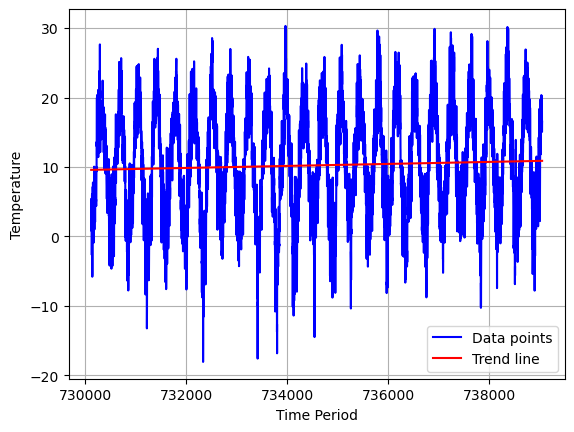

{'slope': 0.00014518002322880372, 'intercept': -96.41315331010453}

In [55]:
theil_sen=theil_sen_slope_estimator(a,b)
theil_sen

# The test confirms there was an upward trend in the data

In [56]:
results = {
    'Test Name': ['Mann-Kendall test (Original)', 
                  
                  'Theil-Sen Slope Estimator', 
                  'Linear Regression (OLS)'],
    
    'Hypothesis Result': [
        man_test_result['Hypothesis Result'], 
        
        f'Trend slope: {theil_sen["slope"]}, Intercept: {theil_sen["intercept"]}', 
        f'R^2 Score: {r2_score(y_linear,lr.predict(X_linear).flatten())}'
    ],
    
    'P-value': [
        man_test_result['p-value'], 
       
        'N/A',  # Theil-Sen doesn't provide a p-value
        daily_p_values_linear_reg
    ]
}

# Convert the dictionary to a pandas DataFrame
test_results_df = pd.DataFrame(results)

# Display the results DataFrame
test_results_df

,Test Name,Hypothesis Result,P-value
0,Mann-Kendall test (Original),Reject H0: There is a trend in the data,0.000013
1,Theil-Sen Slope Estimator,"Trend slope: 0.00014518002322880372, Intercept...",N/A
2,Linear Regression (OLS),R^2 Score: 0.0026945206874857686,"[6.903179318307723e-06, 8.087619859467179e-07]"


# Lets try to find the trend in monthly data

In [57]:
monthly_df = pd.read_csv('Weather_dataset.csv', usecols=['time', 'temperature'])
monthly_df['time'] = pd.to_datetime(monthly_df['time'])
monthly_df.set_index('time', inplace=True)
monthly_df.head()

,temperature
time,
2000-01-01 00:00:00,-0.1
2000-01-01 01:00:00,-0.2
2000-01-01 02:00:00,-0.1
2000-01-01 03:00:00,-0.2
2000-01-01 04:00:00,-0.2


In [58]:
monthly_df=monthly_df.resample('ME').mean()
monthly_df.to_csv('monthly_temp.csv')
monthly_df = pd.read_csv('monthly_temp.csv',parse_dates=['time'],index_col=['time'])
monthly_df.head()

,temperature
time,
2000-01-31,1.366935
2000-02-29,4.038793
2000-03-31,5.237097
2000-04-30,11.134167
2000-05-31,15.863038


In [59]:

monthly_df.describe()

,temperature
count,294.000000
mean,10.225414
std,7.096310
min,-5.995565
25%,4.213340
50%,9.845733
75%,16.679788
max,24.087903


<Figure size 1200x1000 with 0 Axes>

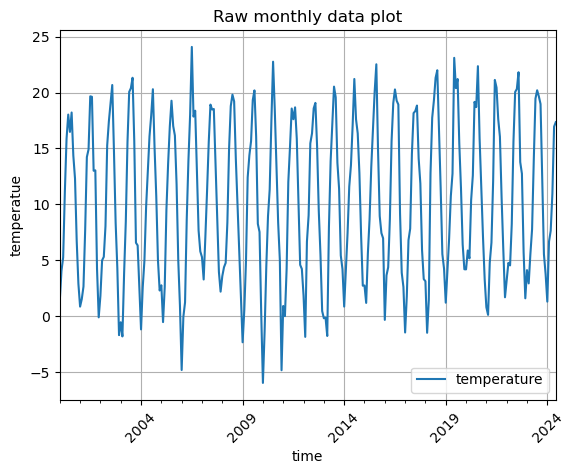

In [60]:
# plotting monthly raw data
plt.figure(figsize=(12,10))
monthly_df.plot(title='Raw monthly data plot')
plt.xlabel('time')
plt.ylabel('temperatue')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

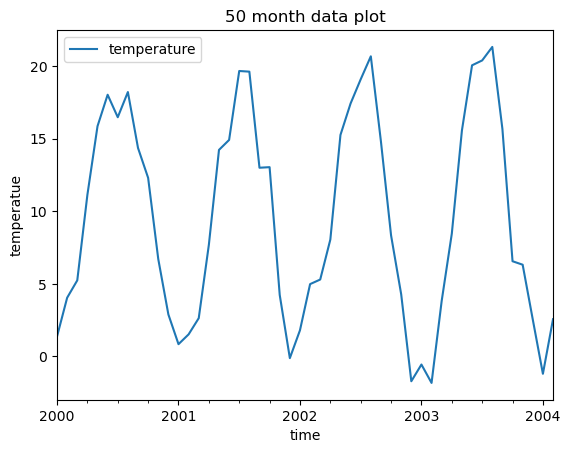

In [61]:
#  plotting 50 month data
monthly_df.iloc[:50,:].plot(title='50 month data plot')
plt.xlabel('time')
plt.ylabel('temperatue')
plt.show()

# Moving averages

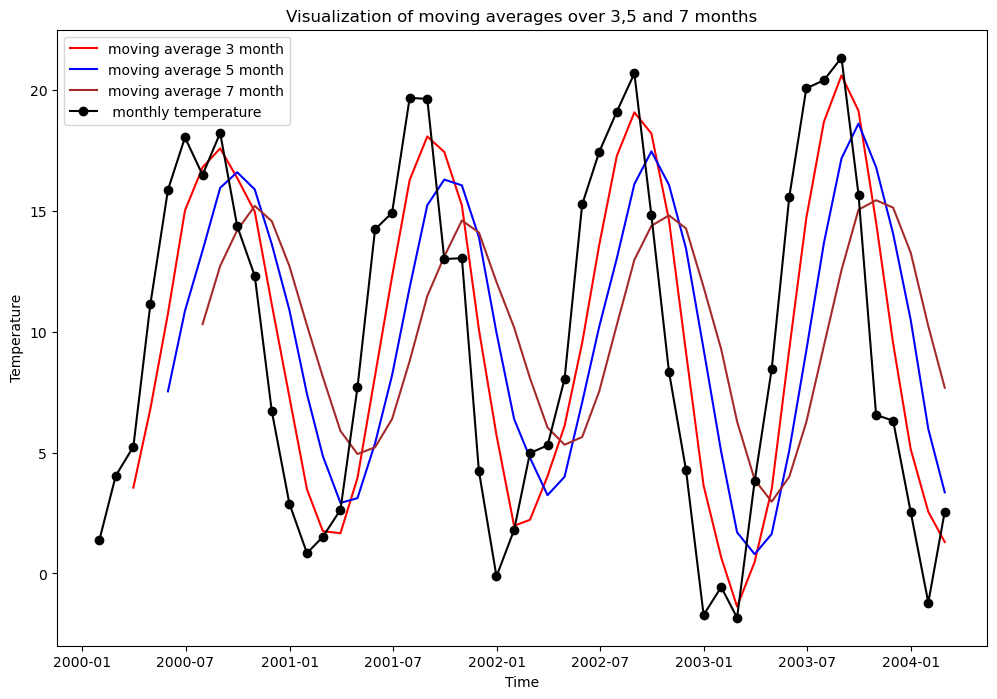

In [62]:
monthly_df['moving_avg_3month']=monthly_df['temperature'].rolling(window=3).mean()
monthly_df['moving_avg_5month']=monthly_df['temperature'].rolling(window=5).mean()
monthly_df['moving_avg_7month']=monthly_df['temperature'].rolling(window=7).mean()
# plotting monthly averages
x=monthly_df.iloc[:50,:]
plt.figure(figsize=(12,8))
plt.plot(x.index,x['moving_avg_3month'],color='red',label='moving average 3 month',)
plt.plot(x.index,x['moving_avg_5month'],color='blue',label='moving average 5 month')
plt.plot(x.index,x['moving_avg_7month'],color='brown',label='moving average 7 month')
plt.plot(x.index,x['temperature'],'-o',color='black',label=' monthly temperature')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.title('Visualization of moving averages over 3,5 and 7 months')
plt.show()


# Linear Regression

Slope of the line fitted to data is [0.00017029]
Y-intercept of the line fitted to data is [-114.87389017]
slope:[0.00017029]  -----  intercept:[-114.87389017]
r2_score: 0.003855922154518021
P-values for predictors: [0.32975181 0.28859243]


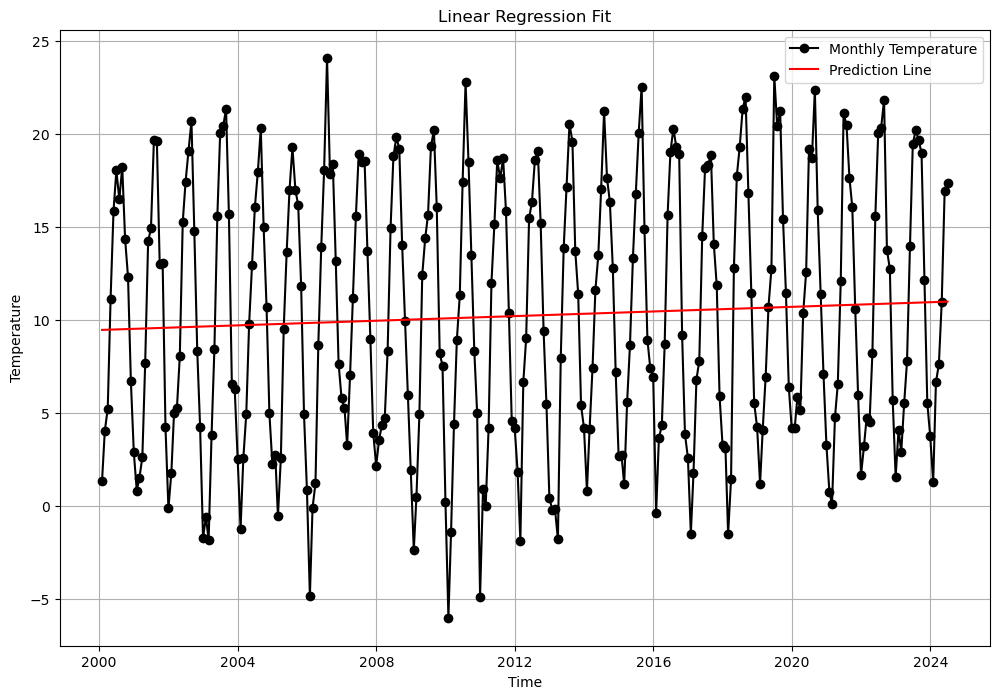

In [63]:
X_linear_month=np.array(monthly_df.index.map(pd.Timestamp.toordinal)).reshape(-1, 1)
y_linear_month=monthly_df['temperature'].values
lr=Mylinearregression()
m,b=lr.fit(X_linear_month,y_linear_month)
print(f'slope:{m}  -----  intercept:{b}')
print("r2_score:",r2_score(y_linear_month,lr.predict(X_linear_month).flatten()))
prediction_line = pd.Series(lr.predict(X_linear_month).flatten(), index=monthly_df.index)
X = sm.add_constant(X_linear_month)  # Adds a constant term for the intercept
model = sm.OLS(y_linear_month, X).fit()
# print(model.summary())

# Access p-values for each predictor
monthly_p_values_linear_reg = model.pvalues


print("P-values for predictors:", monthly_p_values_linear_reg)

plt.figure(figsize=(12, 8))
plt.plot(monthly_df.index, monthly_df['temperature'],'-o',color='black',label='Monthly Temperature')
plt.plot(monthly_df.index, prediction_line,color='red',label='Prediction Line')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.title('Linear Regression Fit')
plt.grid(True)
plt.show()


# Mann kendall test

In [64]:
monthly_original_mann_kendall_result=mann_kendall_test(monthly_df['temperature'],alpha=0.05)
monthly_original_mann_kendall_result

{'Result of Mann-kendall test': 'See below',
 'Hypothesis Result': 'Accept H0: There is no trend in the data',
 'S': 1860.0,
 'Variance of S': 2837899.3333333335,
 'p-value': 0.26980065221726934,
 'Trend': 'no trend'}

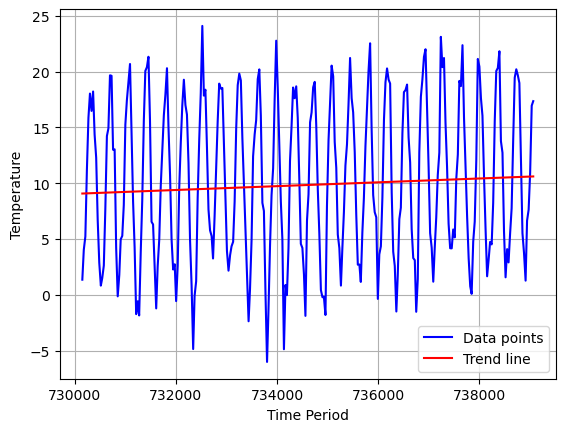

{'slope': 0.0001715307215559235, 'intercept': -116.16210777387212}

In [65]:
c=monthly_df.index.map(pd.Timestamp.toordinal).values
d=monthly_df['temperature'].values
monthly_theil_sen=theil_sen_slope_estimator(c,d)
monthly_theil_sen

In [66]:
results = {
    'Test Name': ['Mann-Kendall test (Original)', 
                  
                  'Theil-Sen Slope Estimator', 
                  'Linear Regression (OLS)'
    ],
    'Hypothesis Result': [
        monthly_original_mann_kendall_result['Hypothesis Result'], 
      
         f'Trend slope: {monthly_theil_sen["slope"]}, Intercept: {monthly_theil_sen["intercept"]}', 
        'R^2 Score:' + str(r2_score(y_linear_month, lr.predict(X_linear_month).flatten()))
    ],
    
     'P-value': [
        monthly_original_mann_kendall_result['p-value'], 
       
        'N/A',  # No p-value for Theil-Sen
        monthly_p_values_linear_reg  # No p-value directly for linear regression, you could calculate it if needed
    ]
}

# Convert the dictionary to a pandas DataFrame
test_results_df = pd.DataFrame(results)

# Display the results DataFrame
test_results_df

,Test Name,Hypothesis Result,P-value
0,Mann-Kendall test (Original),Accept H0: There is no trend in the data,0.269801
1,Theil-Sen Slope Estimator,"Trend slope: 0.0001715307215559235, Intercept:...",N/A
2,Linear Regression (OLS),R^2 Score:0.003855922154518021,"[0.32975180574689467, 0.2885924335513759]"


# Seperate monthly data mann kenndall test

In [67]:
 def mann_kendall_test(data):
    """
    Perform the Mann-Kendall test on a time series.
    
    Returns:
    Dictionary with results
    """
    n = len(data)
    data = np.array(data)
    diff_matrix = data - data[:, None]
    S = np.sum(np.sign(diff_matrix[np.triu_indices(n, k=1)]))
    
    # Compute variance of S
    _, counts = np.unique(data, return_counts=True)
    ties = counts[counts > 1]
    tie_correction_term = np.sum(ties * (ties - 1) * (2 * ties + 5))
    variance_s = (n * (n - 1) * (2 * n + 5) - tie_correction_term) / 18
    
    # Compute Z-statistic
    if S > 0:
        Z = (S - 1) / np.sqrt(variance_s)
    elif S < 0:
        Z = (S + 1) / np.sqrt(variance_s)
    else:
        Z = 0
    
    # Two-tailed p-value
    p_value = 2 * (1 - norm.cdf(abs(Z)))
    
    return {
        'S': S,
        'Variance': variance_s,
        'Z-value': Z,
        'P-value': p_value,
        'Trend': 'Trend Detected' if p_value < 0.05 else 'No Trend'
    }

def mann_kendall_monthly_analysis(df, column_name):
    """
    Perform the Mann-Kendall test for each month individually.
    
    Returns:
    DataFrame with results
    """
    results = []
    grouped = df.groupby(df.index.month)
    
    for month, group in grouped:
        result = mann_kendall_test(group[column_name].values)
        result['Month'] = month
        results.append(result)
    
    return pd.DataFrame(results)


# Monthly trends
monthly_results_df = mann_kendall_monthly_analysis(monthly_df, 'temperature')
print("Monthly Results:")
monthly_results_df


Monthly Results:


,S,Variance,Z-value,P-value,Trend,Month
0,52.0,1833.333333,1.191103,0.233613,No Trend,1
1,54.0,1833.333333,1.237813,0.215785,No Trend,2
2,56.0,1833.333333,1.284523,0.198959,No Trend,3
3,-8.0,1833.333333,-0.163485,0.870137,No Trend,4
4,-22.0,1833.333333,-0.490454,0.623812,No Trend,5
5,101.0,1832.333333,2.336134,0.019484,Trend Detected,6
6,60.0,1625.333333,1.463460,0.143342,No Trend,7
7,50.0,1625.333333,1.215416,0.224208,No Trend,8
8,66.0,1625.333333,1.612286,0.106900,No Trend,9
9,42.0,1625.333333,1.016981,0.309163,No Trend,10


# Lets try to find the if trend exists using modified mann kendal test

In [68]:
import numpy as np
import pandas as pd

def theil_sen_slope_estimator(x, y):
    """
    Compute the Theil-Sen slope estimator for a given x and y.
    
    Parameters:
        x (list or array): Independent variable (e.g., time)
        y (list or array): Dependent variable (e.g., temperature)
        
    Returns:
        dict: A dictionary containing slope and intercept.
    """
    x = np.array(x)
    y = np.array(y)
    n = len(x)
    slopes = []
    
    for i in range(n - 1):
        for j in range(i + 1, n):
            if x[j] != x[i]:  # Avoid division by zero
                slopes.append((y[j] - y[i]) / (x[j] - x[i]))
    
    slope = np.median(slopes)  # Theil-Sen estimator
    x_median = np.median(x)
    y_median = np.median(y)
    intercept = y_median - slope * x_median
    
    return {
        'slope': slope,
        'intercept': intercept
    }

def calculate_monthly_trends(df, time_col, value_col):
    """
    Apply the Theil-Sen slope estimator for each month separately.

    Parameters:
        df (DataFrame): Data containing time and temperature values.
        time_col (str): Column name for time (assumed to be in datetime format).
        value_col (str): Column name for the temperature or dependent variable.
        
    Returns:
        DataFrame: Monthly trend results with slope and intercept.
    """
    df[time_col] = pd.to_datetime(df.index)  # Ensure datetime format
    df['Month'] = df[time_col].dt.month  # Extract month
    df['Year'] = df[time_col].dt.year  # Extract year
    
    results = []
    
    for month in range(1, 13):  # Loop through each month
        monthly_data = df[df['Month'] == month]
        if len(monthly_data) > 1:  # Ensure enough data points
            trend = theil_sen_slope_estimator(monthly_data['Year'], monthly_data[value_col])
            results.append({
                'Month': month,
                'Slope': trend['slope'],
                'Intercept': trend['intercept']
            })
    
    return pd.DataFrame(results)

# Example usage:
# df = pd.read_csv("your_data.csv")  # Load your dataset
results_df = calculate_monthly_trends(monthly_df, "time", "temperature")
print(results_df)

    Month     Slope   Intercept
0       1  0.086148 -172.141050
1       2  0.105088 -209.657906
2       3  0.058868 -113.514687
3       4 -0.008237   25.491772
4       5 -0.022492   59.634493
5       6  0.104608 -192.438929
6       7  0.052850  -86.373490
7       8  0.067085 -115.513306
8       9  0.065494 -116.429367
9      10  0.075719 -141.259882
10     11  0.039486  -73.808633
11     12  0.083264 -164.919141


In [69]:
monthly_df

,temperature,moving_avg_3month,moving_avg_5month,moving_avg_7month,time,Month,Year
time,,,,,,,
2000-01-31,1.366935,NaN,NaN,NaN,2000-01-31,1,2000
2000-02-29,4.038793,NaN,NaN,NaN,2000-02-29,2,2000
2000-03-31,5.237097,3.547608,NaN,NaN,2000-03-31,3,2000
2000-04-30,11.134167,6.803352,NaN,NaN,2000-04-30,4,2000
2000-05-31,15.863038,10.744767,7.528006,NaN,2000-05-31,5,2000
...,...,...,...,...,...,...,...
2024-02-29,6.654454,3.892345,5.870131,9.711764,2024-02-29,2,2024
2024-03-31,7.628226,5.188357,4.966663,7.993292,2024-03-31,3,2024
2024-04-30,10.959444,8.414041,6.052941,6.848332,2024-04-30,4,2024


In [74]:
def run_pettitt(data_series):
    result = pettitt_test(data_series.values)
    change_year = data_series.index[result.cp] if result.h else "No"
    return {
        "KT": round(result.U, 2),
        "P-value": round(result.p, 2),
        "Change point (Year)": change_year
    }


results = []

# Monthly Analysis
for month in range(1, 13):
    month_data = monthly_df[monthly_df.index.month == month]['temperature']
    res = run_pettitt(month_data)
    results.append({
        'Months/Seasons': pd.Timestamp(1900, month, 1).strftime('%B'),
        **res
    })


In [75]:
x=pd.DataFrame(results)

In [76]:
print(x)

   Months/Seasons     KT  P-value  Change point (Year)
0         January   66.0     0.25                   No
1        February   72.0     0.17                   No
2           March   68.0     0.22                   No
3           April   44.0     0.70                   No
4             May   40.0     0.80                   No
5            June  110.0     0.01  2016-06-30 00:00:00
6            July   63.0     0.24                   No
7          August   71.0     0.14                   No
8       September   62.0     0.26                   No
9         October   53.0     0.42                   No
10       November   44.0     0.64                   No
11       December   83.0     0.06                   No
